20200124

7章 畳み込みニューラルネットワーク

# CNN、全体の構造

- 「Convolutionレイヤ（畳み込み層）」
- 「Poolingレイヤ（プーリング層）」  
が新たに登場

全結合層によるネットワークの例

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_d8162454-7614-6286-69f9-d12cbdd20158.png">

CNNのネットワークの例

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_d7b35f4b-654c-5a13-af99-ca0a00bd140d.png">

一般的なCNNの特徴
- 「Convolution - ReLU - (Pooling)」という流れ
- Pooling層は省略されることもある
- 出力に近い層では「Affine - ReLU」という組み合わせが用いられる
- 最後の出力層は「Affine - Softmax」の組み合わせ

# 畳み込み層

## 全結合層の問題点

全結合の問題点とはデータの構造が"無視"されてしまう

CNNでは、  
- 畳み込み層の入出力データを特徴マップ(feature map)
- 入力データを入力特徴マップ(feature map)
- 出力データを出力特徴マップ(feature map)

## 畳み込み演算

<img src="./fig/">

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_2f577775-1e27-fe09-afe6-5deba3fa3fae.png">

演算例)

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_09bf99d5-ddbd-b330-421e-615f8c2518b0.png">

バイアスを加えた演算

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_deb7792a-1920-d40b-fc7f-41ab6a6da50d.png">

### パディング

入力データの周囲に固定データ（例えば0）を埋めること

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_534f3de7-43e3-d9d1-aa16-aa5facc65482.png">

### ストライド

フィルターを適用する位置の間隔のこと

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_3224015f-f990-3de6-5f20-a5ad3c20b74e.png">

### 出力サイズの関係

<img src="./fig/スクリーンショット 2020-01-25 17.04.34.png">

### ブロックで考える

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_4271ea14-391f-cb75-6f22-42f7dde9d622.png">

↑チャンネル数が1の特徴マップ

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_eeac59e1-522d-edda-b66f-0b1d500cc3e9.png">

↑チャンネル方向にも複数持たせる

バイアス追加も

### バッチ処理

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_1148d04d-a19b-30d8-2361-c112485ddeab.png">

# プーリング層

縦・横方向の空烏瞰を小さくする演算

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_345d90c3-e40d-6f90-a83e-824719c678bd.png">

特徴
- 学習するパラメータがない  
単一の操作だから
- チャンネル数は変化しない
- 微小な位置変化に対してロバスト（頑強）

# Convolution/Poolingレイヤの実装

## 4次元配列

↓

im2colによる展開

<img src="./fig/https___qiita-image-store.s3.amazonaws.com_0_197508_e4f0a475-e757-732d-f61b-0d2668550a2a.png">

Convolutionレイヤの実装

In [1]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None

        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        #reshape関数に-1を指定すると、多次元配列の辻褄が合うように要素数をまとめてくれる
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        #最後に出力サイズを適切な形状に整形する
        # reshapeは出力サイズを指定の形状を再構成
        # transposeは軸の順番を入れ替えている
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        # 逆行列の計算自体は次の２行でしており、Affineの時と同じ、違うのは行列の次元の辻褄あわせだけ
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)

        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        #im2colと逆の処理
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

poolingレイヤの実装

In [2]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        #flattenは構造を１次元配列に入れ直すこと
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

# CNNの実装

In [3]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

学習

train loss:2.300427500136455
=== epoch:1, train acc:0.181, test acc:0.194 ===
train loss:2.2980967367045246
train loss:2.2927351747413085
train loss:2.2900541195935875
train loss:2.2811471061339694
train loss:2.271016245818602
train loss:2.248639615122298
train loss:2.222846749998564
train loss:2.2329557619094427
train loss:2.2005974396312014
train loss:2.162799468465598
train loss:2.1218000545211355
train loss:2.112656163516271
train loss:2.046681574166948
train loss:1.9675245907530001
train loss:1.8634725285148648
train loss:1.9133964238756227
train loss:1.7810332078238493
train loss:1.7136300096099994
train loss:1.6797059565169252
train loss:1.572077084026989
train loss:1.4683722765588418
train loss:1.3929504734092988
train loss:1.3726913363314528
train loss:1.292384868480863
train loss:1.219003162672609
train loss:1.1916319460318154
train loss:1.1127018820021342
train loss:0.8985942633557112
train loss:0.8286515495520023
train loss:1.0114786619363934
train loss:0.7759245246304803
t

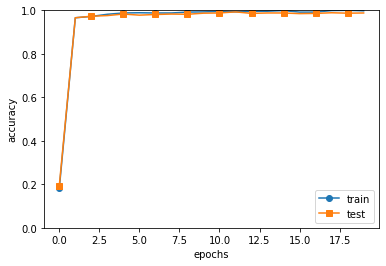

In [5]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## CNNの可視化

１層目の重みの可視化

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

- 学習前：フィルターがランダムに初期化されているため白黒の濃淡に規則性がない
- 学習後：規則性がある

このような規則性があるフィルターは"何を見ている"のか
・エッジ：色が変化する境目
・ブロブ：局所的に塊のある領域